In [11]:
import pandas as pd
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBClassifier
from sklearn.tree import  plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [12]:

from sklearn.model_selection import StratifiedKFold

from sklearn.calibration import LabelEncoder


bcancer = pd.read_csv('BreastCancer.csv', index_col=0)
lbl = LabelEncoder()
bcancer['Class'] = lbl.fit_transform(bcancer['Class'])

X = bcancer.drop('Class', axis=1)
y = bcancer['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=23, stratify=y)


W/O Passthrough

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


lr = LogisticRegression()
svm = SVC(kernel='linear', random_state=23, probability=True)
dtc = DecisionTreeClassifier(random_state=23)
rf = RandomForestClassifier(random_state=23)

stack = StackingClassifier([('LR',lr),('SVM',svm),('TREE',dtc)],final_estimator=rf)
stack.fit(X_train, y_train) #Executes all ops on train set
y_pred = stack.predict(X_test) #Executes all ops on test set
print(accuracy_score(y_test, y_pred))

0.9523809523809523


With Passthrough

In [14]:
lr = LogisticRegression()
svm = SVC(kernel='linear', random_state=23, probability=True)
dtc = DecisionTreeClassifier(random_state=23)
rf = RandomForestClassifier(random_state=23)

stack = StackingClassifier([('LR',lr),('SVM',svm),('TREE',dtc)],final_estimator=rf, passthrough=True)
stack.fit(X_train, y_train) #Executes all ops on train set
y_pred = stack.predict(X_test) #Executes all ops on test set
print(accuracy_score(y_test, y_pred))

0.9523809523809523


In [15]:
from sklearn.ensemble import GradientBoostingClassifier


gbm = GradientBoostingClassifier(random_state=23)
stack = StackingClassifier([('LR',lr),('SVM',svm),('TREE',dtc)],final_estimator=gbm, passthrough=True)
stack.fit(X_train, y_train) #Executes all ops on train set
y_pred = stack.predict(X_test) #Executes all ops on test set
print(accuracy_score(y_test, y_pred))

0.9619047619047619


In [18]:
params = {'TREE__max_depth':[2, 3, 4, 5, 6, None],'TREE__min_samples_split':[2,5,10],'TREE__min_samples_leaf':[1,3,5,7,10,15],'LR__penalty':['l1','l2',None],
          'SVM__C':np.linspace(0.001,3,5),'final_estimator__learning_rate': [0.01,0.2],'final_estimator__max_depth':[2, 3, 4, 5, 6, None]}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
gcv = GridSearchCV(stack, param_grid=params, cv=kfold, n_jobs=4)
gcv.fit(X,y)
print(gcv.best_params_)
print(gcv.best_score_)

In [ ]:
params = {'TREE__max_depth':[2, 3, 4, 5, 6, None],'TREE__min_samples_split':[2,5,10],'TREE__min_samples_leaf':[1,3,5,7,10,15],'LR__penalty':['l1','l2',None],
          'SVM__C':np.linspace(0.001,3,5),'final_estimator__learning_rate': [0.01,0.2],'final_estimator__max_depth':[2, 3, 4, 5, 6, None]}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
gcv = RandomGridSearchCV(stack, param_grid=params, cv=kfold, n_jobs=4)
gcv.fit(X,y)
print(gcv.best_params_)
print(gcv.best_score_)

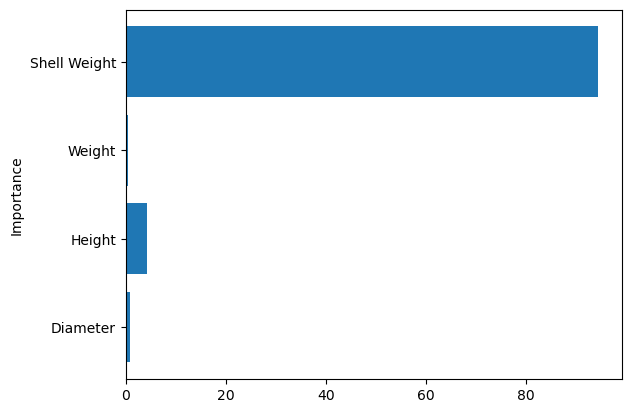

In [ ]:
bm_cgbm= stack.best_estimator_

df_imp = pd.DataFrame({'variable':bm_cgbm.feature_names_, 'importance':bm_cgbm.feature_importances_})
df_imp = df_imp[df_imp['importance']>0.0001]
df_imp.sort_values(by='importance',ascending=False)
plt.barh(df_imp['variable'],df_imp['importance'])
plt.ylabel('Importance')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf =RandomForestClassifier(random_state=23)
params = {'max_features':[3, 4, 5, 6]}
StratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
gcv = GridSearchCV(rf, param_grid=params, cv=StratifiedKFold)
gcv.fit(X,y)
print(gcv.best_params_)
print(gcv.best_score_)

{'max_features': 3}
0.5697331564704105


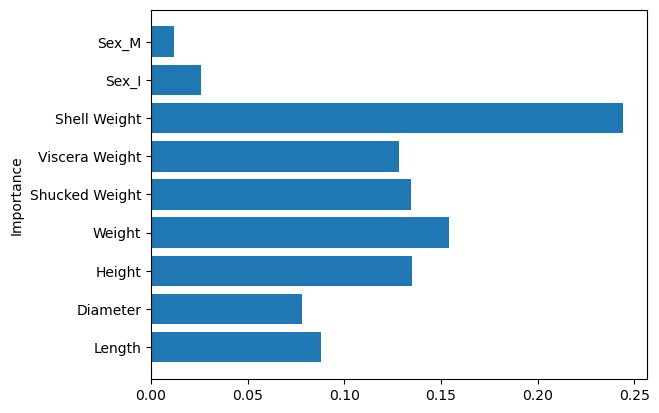

In [ ]:
bm_rg = gcv.best_estimator_

df_imp = pd.DataFrame({'variable':bm_rg.feature_names_in_, 'importance':bm_rg.feature_importances_})
df_imp = df_imp[df_imp['importance']>0.0001]
df_imp.sort_values(by='importance',ascending=True)
plt.barh(df_imp['variable'],df_imp['importance'])
plt.ylabel('Importance')
plt.show()

For comparison

In [ ]:
from sklearn.tree import DecisionTreeClassifier


dtc =DecisionTreeClassifier(random_state=23)
params = {'max_depth':[3, 4, 5, 6], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,3,5,7,10,15]}
StratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
gcv = GridSearchCV(dtc, param_grid=params, cv=StratifiedKFold)
gcv.fit(X,y)
print(gcv.best_params_)
print(gcv.best_score_)

{'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 2}
0.5466986635551383


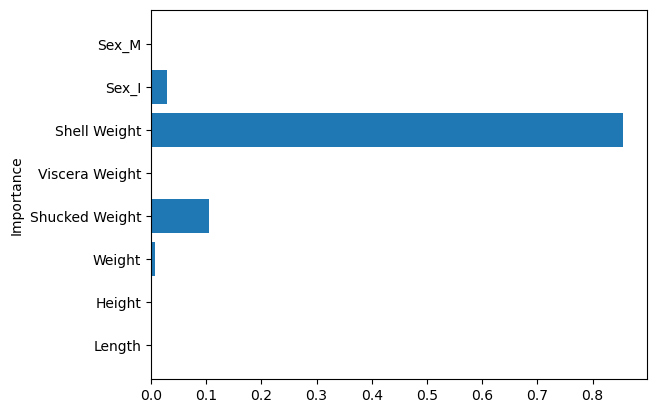

In [ ]:
bm_dtc = gcv.best_estimator_

df_imp = pd.DataFrame({'variable':bm_dtc.feature_names_in_, 'importance':bm_dtc.feature_importances_})
df_imp = df_imp[df_imp['importance']>0.0001]
df_imp.sort_values(by='importance',ascending=True)
plt.barh(df_imp['variable'],df_imp['importance'])
plt.ylabel('Importance')
plt.show()